# **Project: Topic Modelling**

- Karyl Abigail Grasparil
- Mariah Anjannelle A. Quinquito

## **Executive Summary**
In this project, we performed topic modeling on a dataset containing research papers categorized by subject, sourced from [Kaggle](https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts?select=arxiv_data.csv). The objective was to identify hidden topics within the text data using two popular topic modeling techniques: LDA and NMF.

The preprocessing phase involved cleaning and preparing the text data, which included standardizing case, removing stop words, lemmatizing, and tokenizing. Following this, we vectorized the data using techniques like TF-IDF and CountVectorizer to convert the text into numerical format.

We conducted a series of experiments to develop six LDA and NMF models with different hyperparameters. The models were evaluated based on metrics such as reconstruction error, coherence scores, and topic-word distributions. Additionally, we used pyLDAvis to visualize the topics generated by the LDA model for interpretability.

The results demonstrate that the NMF model outperformed LDA in both quantitative and qualitative metrics. With a significantly lower reconstruction error and a higher number of interpretable topics, NMF proved to be more effective for this use case. Its ability to extract granular and coherent topics aligned well with the dataset's structure, providing actionable insights for stakeholders.

The findings from the best NMF model are discussed in detail, along with recommendations for further improvements. These outcomes are expected to benefit stakeholders by providing deeper insights into research trends and themes within academic publications, ensuring meaningful categorization and analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## **Preprocessing**

Load the Dataset

In [2]:
# Load dataset
# Load the dataset
df = pd.read_csv("arXiv-DataFrame.csv")
df.head()

,Unnamed: 0,id,Title,Summary,Author,Link,Publish Date,Update Date,Primary Category,Category
0,0,cs/9308101v1,Dynamic Backtracking,Because of their occasional need to return to ...,M. L. Ginsberg,http://arxiv.org/pdf/cs/9308101v1,1993-08-01T00:00:00Z,1993-08-01T00:00:00Z,cs.AI,['cs.AI']
1,1,cs/9308102v1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,M. P. Wellman,http://arxiv.org/pdf/cs/9308102v1,1993-08-01T00:00:00Z,1993-08-01T00:00:00Z,cs.AI,['cs.AI']
2,2,cs/9309101v1,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,I. P. Gent,http://arxiv.org/pdf/cs/9309101v1,1993-09-01T00:00:00Z,1993-09-01T00:00:00Z,cs.AI,['cs.AI']
3,3,cs/9311101v1,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,F. Bergadano,http://arxiv.org/pdf/cs/9311101v1,1993-11-01T00:00:00Z,1993-11-01T00:00:00Z,cs.AI,['cs.AI']
4,4,cs/9311102v1,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,J. C. Schlimmer,http://arxiv.org/pdf/cs/9311102v1,1993-11-01T00:00:00Z,1993-11-01T00:00:00Z,cs.AI,['cs.AI']


In [3]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Unnamed: 0          0
id                  0
Title               0
Summary             0
Author              0
Link                0
Publish Date        0
Update Date         0
Primary Category    0
Category            0
dtype: int64


Data Preprocessing

In [4]:
# Select text column and sample directly from the Series
text_data = df['Summary']

# Sample 5 random rows
sample_data = text_data.sample(5)

# Print the sampled data
print("Sample Text Data:", sample_data.tolist())

# Print the length of the text data
print("LENGTH:", len(text_data))

Sample Text Data: ['Personalized article recommendation is important to improve user engagement on news sites. Existing work quantifies engagement primarily through click rates. We argue that quality of recommendations can be improved by incorporating different types of "post-read" engagement signals like sharing, commenting, printing and e-mailing article links. More specifically, we propose a multi-faceted ranking problem for recommending news articles where each facet corresponds to a ranking problem to maximize actions of a post-read action type. The key technical challenge is to estimate the rates of post-read action types by mitigating the impact of enormous data sparsity, we do so through several variations of factor models. To exploit correlations among post-read action types we also introduce a novel variant called locally augmented tensor (LAT) model. Through data obtained from a major news site in the US, we show that factor models significantly outperform a few baseline IR 

In [5]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AJ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Define preprocessing function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase and clean
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_text'] = text_data.apply(preprocess_text)
print("Sample of Preprocessed Text:")
print(df['cleaned_text'].head())

# Print the length of the text data
print("\nLENGTH:", len(df['cleaned_text']))

Sample of Preprocessed Text:
0    occasional need return shallow point search tr...
1    market price system constitute wellunderstood ...
2    describe extensive study search gsat approxima...
3    real logic programmer normally use cut effecti...
4    support goal allowing user record retrieve inf...
Name: cleaned_text, dtype: object

LENGTH: 53474


## **Model Development**

In [7]:
# Vectorize for LDA
vectorizer = CountVectorizer(max_df=0.8, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_text'])
print("LDA Vectorized Shape:", dtm.shape)

LDA Vectorized Shape: (53474, 14236)


In [8]:
# Vectorize for NMF
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, stop_words='english', max_features=5000)
tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
print("NMF Vectorized Shape:", tfidf.shape)

NMF Vectorized Shape: (53474, 5000)


In [9]:
# Define the function to reformat output matrices into readable tables
def get_topics(mod, vec, names, docs, ndocs, nwords):
    # Word to topic matrix
    W = mod.components_
    W_norm = W / W.sum(axis=1)[:, np.newaxis]
    
    # Topic to document matrix
    H = mod.transform(vec)
   
    W_dict = {}
    H_dict = {}
   
    for tpc_idx, tpc_val in enumerate(W_norm):
        topic = f"Topic{tpc_idx + 1}"
       
        # Formatting W (Word-Topic)
        W_indices = tpc_val.argsort()[::-1][:nwords]
        W_names_values = [(round(tpc_val[j], 4), names[j]) for j in W_indices]
        W_dict[topic] = W_names_values
       
        # Formatting H (Document-Topic)
        H_indices = H[:, tpc_idx].argsort()[::-1][:ndocs]
        H_names_values = [(round(H[:, tpc_idx][j], 4), docs[j]) for j in H_indices]
        H_dict[topic] = H_names_values
       
    # Convert to DataFrames
    W_df = pd.DataFrame(W_dict, index=[f"Word{i+1}" for i in range(nwords)])
    H_df = pd.DataFrame(H_dict, index=[f"Doc{i+1}" for i in range(ndocs)])
       
    return W_df, H_df

Train and Evaluate LDA Models with Different Hyperparameters

In [10]:
# Train and evaluate LDA models with specified parameters, including coherence and perplexity.
def train_lda_models(data, vectorizer, num_topics_list, alpha=None, beta=None, ndocs=5, nwords=10, docs=None):
    results = []
    feature_names = vectorizer.get_feature_names_out()

    # Convert sparse matrix to Gensim-compatible format
    corpus = [
        [(i, freq) for i, freq in zip(row.indices, row.data)]
        for row in data
    ]
    dictionary = Dictionary([feature_names.tolist()])

    for num_topics in num_topics_list:
        print(f"\nTraining LDA with {num_topics} topics, alpha={alpha}, beta={beta}...")

        # Train sklearn's LDA model
        lda_model = LatentDirichletAllocation(
            n_components=num_topics,
            max_iter=10,
            random_state=42,
            doc_topic_prior=alpha,
            topic_word_prior=beta
        )
        lda_model.fit(data)

        # Compute perplexity
        perplexity = lda_model.perplexity(data)


        # Compute coherence score using Gensim
        gensim_lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=10,
            alpha=alpha,
            eta=beta,
            random_state=42
        )
        coherence_model = CoherenceModel(
            model=gensim_lda_model,
            texts=[[dictionary[id] for id, _ in doc] for doc in corpus],
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()

        print(f"Coherence Score: {coherence_score:.4f}, Perplexity: {perplexity:.4f}")

        # Generate Word-Topic and Document-Topic Tables for interpretability
        W_df, H_df = get_topics(lda_model, data, feature_names, docs, ndocs, nwords)

        # Store results
        results.append({
            "num_topics": num_topics,
            "model": lda_model,
            "coherence_score": coherence_score,
            "perplexity": perplexity,
            "word_topic_table": W_df,
            "doc_topic_table": H_df
        })

    return results

In [11]:
# Define hyperparameters
num_topics_list = [5, 10, 15, 20, 25, 30]  # Number of topics
alpha = 0.5  # Document-topic distribution sparsity
beta = 0.1   # Topic-word distribution sparsity

# Train and evaluate LDA models
lda_results = train_lda_models(
    dtm, 
    vectorizer, 
    num_topics_list, 
    alpha=alpha, 
    beta=beta, 
    docs=df['cleaned_text']
    )

# Find the best LDA model based on coherence score
best_lda_model = max(lda_results, key=lambda x: x["coherence_score"])


Training LDA with 5 topics, alpha=0.5, beta=0.1...
Coherence Score: 0.5261, Perplexity: 2481.7115

Training LDA with 10 topics, alpha=0.5, beta=0.1...
Coherence Score: 0.5617, Perplexity: 2399.5169

Training LDA with 15 topics, alpha=0.5, beta=0.1...
Coherence Score: 0.5554, Perplexity: 2400.8910

Training LDA with 20 topics, alpha=0.5, beta=0.1...
Coherence Score: 0.5383, Perplexity: 2469.6029

Training LDA with 25 topics, alpha=0.5, beta=0.1...
Coherence Score: 0.5216, Perplexity: 2467.0952

Training LDA with 30 topics, alpha=0.5, beta=0.1...
Coherence Score: 0.5109, Perplexity: 2542.0982


In [12]:
# Extract scores
num_topics = [result['num_topics'] for result in lda_results]
coherence_scores = [result['coherence_score'] for result in lda_results]
perplexities = [result['perplexity'] for result in lda_results]

In [13]:
# Extract coherence and perplexity scores
num_topics = [result["num_topics"] for result in lda_results]
coherence_scores = [result["coherence_score"] for result in lda_results]
perplexities = [result["perplexity"] for result in lda_results]

In [14]:
# Display the Word-Topic Table for the best model
print("Word-Topic Table for Best Model:")
print(best_lda_model["word_topic_table"])

Word-Topic Table for Best Model:
                       Topic1               Topic2                  Topic3  \
Word1         (0.0148, model)     (0.0413, method)         (0.0278, model)   
Word2         (0.0098, state)   (0.0143, proposed)  (0.0204, distribution)   
Word3         (0.0077, phase)       (0.013, image)          (0.0145, data)   
Word4      (0.0075, equation)       (0.012, using)     (0.0097, parameter)   
Word5          (0.0074, cell)      (0.0106, based)       (0.0079, network)   
Word6        (0.0072, energy)      (0.0104, model)         (0.0074, study)   
Word7       (0.0067, dynamic)   (0.0098, approach)       (0.0073, cluster)   
Word8        (0.0063, result)     (0.0093, signal)        (0.0069, sample)   
Word9         (0.0062, field)  (0.0092, technique)      (0.0067, analysis)   
Word10  (0.0062, interaction)  (0.0085, algorithm)     (0.0064, estimator)   

                    Topic4                   Topic5                 Topic6  \
Word1      (0.0169, space)    

In [15]:
print(f"Perplexity: {best_lda_model['perplexity']}")

Perplexity: 2399.5169028361092


In [16]:
print(f"Coherence Score: {best_lda_model['coherence_score']}")

Coherence Score: 0.5616542888599549


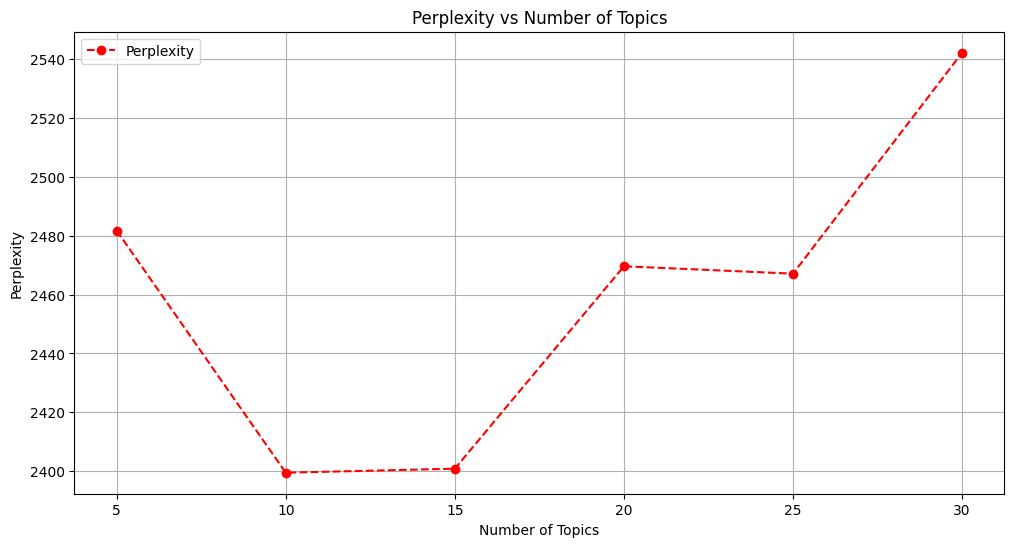

In [17]:
# Plot perplexity scores
plt.figure(figsize=(12, 6))
plt.plot(num_topics, perplexities, marker='o', linestyle='--', color='r', label='Perplexity')
plt.title("Perplexity vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.xticks(num_topics)
plt.grid()
plt.legend()
plt.show()

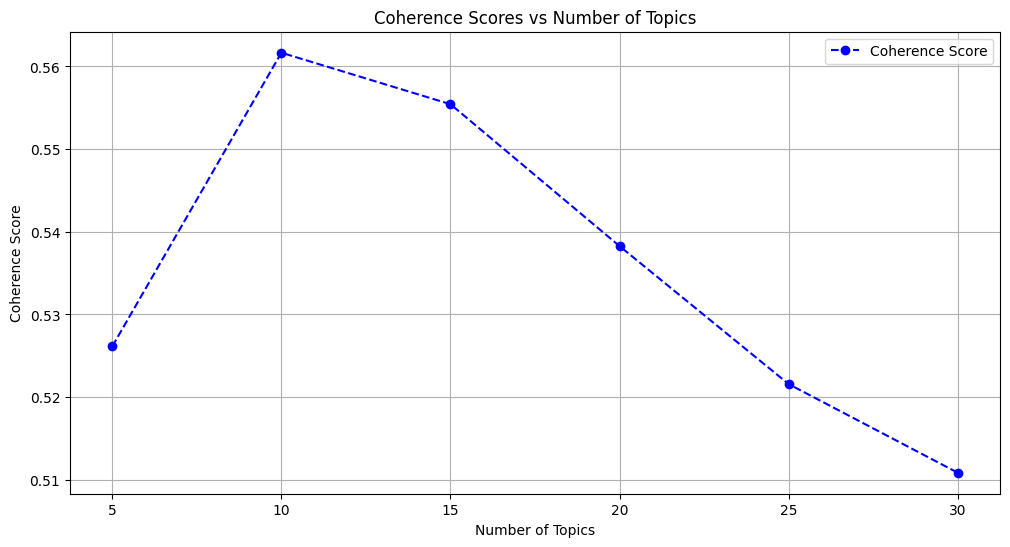

In [18]:
# Plot coherence scores
plt.figure(figsize=(12, 6))
plt.plot(num_topics, coherence_scores, marker='o', linestyle='--', color='b', label='Coherence Score')
plt.title("Coherence Scores vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.xticks(num_topics)
plt.grid()
plt.legend()
plt.show()

In [19]:
# Calculate and display perplexity for the best LDA model
perplexity = best_lda_model["model"].perplexity(dtm)  # Use the Document-Term Matrix (DTM)
print(f"Perplexity of Best LDA Model: {perplexity:.4f}")

Perplexity of Best LDA Model: 2399.5169


Best LDA Model

In [20]:
# Display number of topics for the best model
print("Best LDA Model Details:")
print(f"Number of Topics: {best_lda_model['num_topics']}")

Best LDA Model Details:
Number of Topics: 10


Train and Evaluate NMF Models with Different Hyperparameters

In [21]:
def evaluate_nmf_model(nmf, data, vectorizer, docs, ndocs=5, nwords=10):
    feature_names = vectorizer.get_feature_names_out()
    # Reconstruction error
    reconstruction_error = mean_squared_error(
        data.toarray(),
        nmf.inverse_transform(nmf.transform(data))
    )
    
    # Sparsity: proportion of non-zero elements in W and H
    W = nmf.transform(data)
    H = nmf.components_
    sparsity_W = np.mean(W != 0)
    sparsity_H = np.mean(H != 0)
    
    # Generate word-topic and document-topic tables for interpretability
    W_df, H_df = get_topics(nmf, data, feature_names, docs, ndocs, nwords)
    
    return reconstruction_error, sparsity_W, sparsity_H, W_df, H_df

In [22]:
def train_and_evaluate_nmf_models(data, vectorizer, docs, num_topics_list, ndocs=5, nwords=10):
    """
    Train and evaluate NMF models with specified numbers of topics.
    """
    results = []
    feature_names = vectorizer.get_feature_names_out()
    
    for num_topics in num_topics_list:
        print(f"\nTraining NMF with {num_topics} topics...")
        nmf = NMF(n_components=num_topics, random_state=42, max_iter=10, init="nndsvd")
        nmf.fit(data)
        
        # Evaluate the model
        reconstruction_error, sparsity_W, sparsity_H, W_df, H_df = evaluate_nmf_model(
            nmf, data, vectorizer, docs, ndocs, nwords
        )
        
        # Store results
        results.append({
            "num_topics": num_topics,
            "reconstruction_error": reconstruction_error,
            "sparsity_W": sparsity_W,
            "sparsity_H": sparsity_H,
            "word_topic_table": W_df,
            "doc_topic_table": H_df
        })
        
        print(f"\nReconstruction Error: {reconstruction_error:.4f}")
        print(f"Sparsity (W): {sparsity_W:.4f}")
        print(f"Sparsity (H): {sparsity_H:.4f}")
        print("\nWord-Topic Table:")
        print(W_df)
        print("\nDocument-Topic Table:")
        print(H_df)
    
    return results

In [23]:
# Define the list of numbers of topics
num_topics_list_nmf = [20, 25, 30, 35, 40, 45]

# Train and evaluate NMF models
nmf_results = train_and_evaluate_nmf_models(
    tfidf,  # TF-IDF matrix
    tfidf_vectorizer,  # Vectorizer
    df["cleaned_text"].tolist(),  # Documents
    num_topics_list_nmf
)

# Select the best model based on reconstruction error
best_nmf_model = min(nmf_results, key=lambda x: x["reconstruction_error"])


Training NMF with 20 topics...


c:\Users\AJ\anaconda3\envs\Nueral-test\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(



Reconstruction Error: 0.0002
Sparsity (W): 0.4813
Sparsity (H): 0.4493

Word-Topic Table:
                       Topic1              Topic2                 Topic3  \
Word1         (0.0069, paper)  (0.0165, manifold)        (0.0152, state)   
Word2          (0.0069, user)   (0.0163, theorem)        (0.0142, phase)   
Word3        (0.0068, design)  (0.0143, operator)        (0.014, energy)   
Word4   (0.0062, application)     (0.0118, prove)  (0.0108, temperature)   
Word5   (0.0061, information)     (0.0116, proof)   (0.0097, transition)   
Word6      (0.0049, language)       (0.0106, map)  (0.0071, interaction)   
Word7      (0.0049, software)     (0.0102, class)     (0.0063, electron)   
Word8   (0.0048, performance)      (0.0089, ring)      (0.0062, lattice)   
Word9      (0.0047, approach)     (0.008, result)      (0.0058, density)   
Word10     (0.0045, research)  (0.0079, category)       (0.0057, effect)   

                       Topic4                Topic5                Topic

c:\Users\AJ\anaconda3\envs\Nueral-test\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(



Reconstruction Error: 0.0002
Sparsity (W): 0.4584
Sparsity (H): 0.4246

Word-Topic Table:
                       Topic1              Topic2                 Topic3  \
Word1          (0.0076, user)  (0.0202, manifold)        (0.0155, state)   
Word2         (0.0075, paper)   (0.0189, theorem)        (0.0133, phase)   
Word3        (0.0072, design)     (0.0139, proof)        (0.013, energy)   
Word4   (0.0066, application)     (0.0132, prove)  (0.0109, temperature)   
Word5   (0.0062, information)       (0.0122, map)   (0.0094, transition)   
Word6      (0.0052, approach)     (0.0102, class)      (0.0077, quantum)   
Word7      (0.0052, research)      (0.0094, ring)  (0.0073, interaction)   
Word8      (0.0052, software)  (0.0093, operator)      (0.0063, lattice)   
Word9    (0.005, performance)    (0.0089, result)      (0.0062, density)   
Word10          (0.0043, new)       (0.0086, let)     (0.0061, electron)   

                        Topic4                Topic5                Topi

c:\Users\AJ\anaconda3\envs\Nueral-test\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(



Reconstruction Error: 0.0002
Sparsity (W): 0.4459
Sparsity (H): 0.4032

Word-Topic Table:
                       Topic1                Topic2                 Topic3  \
Word1         (0.0078, paper)     (0.0294, theorem)       (0.0177, energy)   
Word2        (0.0076, design)        (0.0229, ring)        (0.0155, state)   
Word3   (0.0071, application)       (0.0224, proof)     (0.0092, electron)   
Word4          (0.0069, user)       (0.0167, prove)  (0.0079, temperature)   
Word5      (0.0055, software)         (0.0152, let)  (0.0069, interaction)   
Word6      (0.0053, approach)      (0.0138, result)      (0.0069, quantum)   
Word7   (0.0053, performance)      (0.0136, finite)         (0.0067, wave)   
Word8      (0.0051, research)       (0.0133, ideal)       (0.0066, effect)   
Word9   (0.0048, information)       (0.0114, class)      (0.0064, density)   
Word10          (0.0045, new)  (0.0109, conjecture)     (0.0064, particle)   

                        Topic4                Topi

c:\Users\AJ\anaconda3\envs\Nueral-test\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(



Reconstruction Error: 0.0002
Sparsity (W): 0.4387
Sparsity (H): 0.3871

Word-Topic Table:
                       Topic1               Topic2                 Topic3  \
Word1        (0.0085, design)       (0.0267, ring)        (0.0216, phase)   
Word2   (0.0077, application)        (0.0201, let)   (0.015, temperature)   
Word3          (0.0067, user)      (0.0201, prove)   (0.0136, transition)   
Word4         (0.0063, paper)        (0.0184, map)        (0.0128, state)   
Word5   (0.0059, performance)     (0.0176, finite)      (0.0088, lattice)   
Word6      (0.0058, software)      (0.0174, class)  (0.0067, interaction)   
Word7      (0.0058, approach)      (0.0146, ideal)         (0.0066, spin)   
Word8      (0.0055, research)  (0.0126, dimension)       (0.0065, effect)   
Word9        (0.005, control)     (0.0103, module)      (0.0063, density)   
Word10  (0.0046, development)     (0.0099, result)     (0.0059, critical)   

                        Topic4                Topic5         

c:\Users\AJ\anaconda3\envs\Nueral-test\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(



Reconstruction Error: 0.0002
Sparsity (W): 0.4230
Sparsity (H): 0.3713

Word-Topic Table:
                       Topic1               Topic2                 Topic3  \
Word1          (0.0089, user)        (0.0348, set)        (0.0303, phase)   
Word2   (0.0081, application)     (0.0283, finite)  (0.0204, temperature)   
Word3        (0.0073, design)        (0.0253, map)   (0.0182, transition)   
Word4      (0.0061, software)        (0.0225, let)       (0.011, lattice)   
Word5       (0.006, research)      (0.0192, prove)         (0.0085, spin)   
Word6      (0.0057, approach)  (0.0134, dimension)      (0.008, critical)   
Word7   (0.0057, performance)   (0.0116, sequence)       (0.0069, effect)   
Word8   (0.0056, information)      (0.0104, point)  (0.0068, interaction)   
Word9         (0.0051, paper)    (0.01, condition)     (0.0063, coupling)   
Word10       (0.005, service)     (0.0093, result)         (0.006, order)   

                          Topic4                Topic5       

c:\Users\AJ\anaconda3\envs\Nueral-test\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(



Reconstruction Error: 0.0002
Sparsity (W): 0.4142
Sparsity (H): 0.3574

Word-Topic Table:
                       Topic1                    Topic2  \
Word1        (0.0105, design)         (0.0552, theorem)   
Word2   (0.0091, application)           (0.0441, proof)   
Word3         (0.0081, paper)           (0.0261, prove)   
Word4      (0.0071, software)          (0.0197, result)   
Word5   (0.0071, performance)      (0.0161, conjecture)   
Word6      (0.0063, approach)             (0.0121, let)   
Word7       (0.0061, control)          (0.0097, finite)   
Word8       (0.006, research)  (0.0095, representation)   
Word9   (0.0055, development)            (0.0092, type)   
Word10      (0.0052, present)       (0.0087, condition)   

                       Topic3                   Topic4                Topic5  \
Word1   (0.0246, temperature)       (0.1008, equation)        (0.155, model)   
Word2     (0.011, transition)       (0.0486, solution)   (0.0133, parameter)   
Word3       (0.0101

In [24]:
# Display the best model's results
print("Best NMF Model:")
print(f"Number of Topics: {best_nmf_model['num_topics']}")
print(f"Reconstruction Error: {best_nmf_model['reconstruction_error']:.4f}")

Best NMF Model:
Number of Topics: 45
Reconstruction Error: 0.0002


In [25]:
# Display Word-Topic Table
print("Word-Topic Table for Best Model:")
print(best_nmf_model["word_topic_table"])

Word-Topic Table for Best Model:
                       Topic1                    Topic2  \
Word1        (0.0105, design)         (0.0552, theorem)   
Word2   (0.0091, application)           (0.0441, proof)   
Word3         (0.0081, paper)           (0.0261, prove)   
Word4      (0.0071, software)          (0.0197, result)   
Word5   (0.0071, performance)      (0.0161, conjecture)   
Word6      (0.0063, approach)             (0.0121, let)   
Word7       (0.0061, control)          (0.0097, finite)   
Word8       (0.006, research)  (0.0095, representation)   
Word9   (0.0055, development)            (0.0092, type)   
Word10      (0.0052, present)       (0.0087, condition)   

                       Topic3                   Topic4                Topic5  \
Word1   (0.0246, temperature)       (0.1008, equation)        (0.155, model)   
Word2     (0.011, transition)       (0.0486, solution)   (0.0133, parameter)   
Word3       (0.0101, density)   (0.0208, differential)     (0.0075, dynamic) 

In [26]:
# Display Document-Topic Table
print("Document-Topic Table for Best Model:")
print(best_nmf_model["doc_topic_table"])

Document-Topic Table for Best Model:
                                                 Topic1  \
Doc1  (0.0254, paper present digital right managemen...   
Doc2  (0.0224, legacy adadas development oems center...   
Doc3  (0.0217, agile development process componentba...   
Doc4  (0.0216, communication requirement current fut...   
Doc5  (0.0214, integrated computer control system ic...   

                                                 Topic2  \
Doc1  (0.0847, real part hinftybt dense linftytrbt j...   
Doc2           (0.0813, give natural proof ado theorem)   
Doc3  (0.0777, paper prove extension blaschkelebesgu...   
Doc4  (0.0739, presenting two theorem paper first th...   
Doc5  (0.0732, arvanitakis established recently theo...   

                                                 Topic3  \
Doc1  (0.0855, signature nonfermi liquid behavior ne...   
Doc2  (0.0841, selfconsistent renormalization scheme...   
Doc3  (0.0816, determine critical temperature homoge...   
Doc4  (0.0812, pr

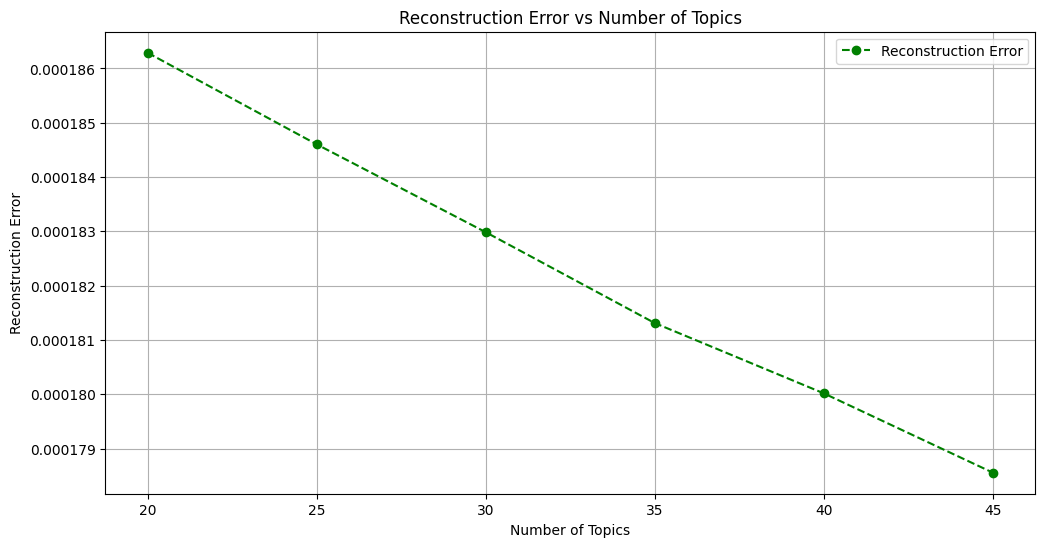

In [27]:
# Extract scores
num_topics = [result['num_topics'] for result in nmf_results]
reconstruction_errors = [result['reconstruction_error'] for result in nmf_results]

# Plot reconstruction errors
plt.figure(figsize=(12, 6))
plt.plot(num_topics, reconstruction_errors, marker='o', linestyle='--', color='g', label='Reconstruction Error')
plt.title("Reconstruction Error vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Reconstruction Error")
plt.xticks(num_topics)
plt.grid()
plt.legend()
plt.show()

Best NMF Model

In [28]:
print("Best NMF Model:")
print(f"Number of Topics: {best_nmf_model['num_topics']}")

Best NMF Model:
Number of Topics: 45


## Discussion

**Best LDA Model**

In [29]:
print(f"Best LDA model:\n{best_lda_model}")

Best LDA model:
{'num_topics': 10, 'model': LatentDirichletAllocation(doc_topic_prior=0.5, random_state=42,
                          topic_word_prior=0.1), 'coherence_score': 0.5616542888599549, 'perplexity': 2399.5169028361092, 'word_topic_table':                        Topic1               Topic2                  Topic3  \
Word1         (0.0148, model)     (0.0413, method)         (0.0278, model)   
Word2         (0.0098, state)   (0.0143, proposed)  (0.0204, distribution)   
Word3         (0.0077, phase)       (0.013, image)          (0.0145, data)   
Word4      (0.0075, equation)       (0.012, using)     (0.0097, parameter)   
Word5          (0.0074, cell)      (0.0106, based)       (0.0079, network)   
Word6        (0.0072, energy)      (0.0104, model)         (0.0074, study)   
Word7       (0.0067, dynamic)   (0.0098, approach)       (0.0073, cluster)   
Word8        (0.0063, result)     (0.0093, signal)        (0.0069, sample)   
Word9         (0.0062, field)  (0.0092, techniqu

Here are the features of the best LDA model:

- **Number of Topics**: 10
- **Perplexity**: 2399.52

Among the LDA models trained, this model achieved a good balance between coherence and perplexity. While perplexity provides insight into how well the model predicts unseen data, coherence ensures the interpretability of the extracted topics. By analyzing the word-topic and document-topic tables, it is evident that the associated words and documents align with meaningful and interpretable topics.

### Abstract Topics for the LDA Model:

1. **Topic 1:**
   - **Dominant Words:** model, state, phase, equation, cell
   - **Possible Topic:** Physical Modeling and Dynamic Systems
   - **Description:** Explores mathematical and physical models related to dynamic systems, equations, and states, often applied in engineering or physics contexts.

2. **Topic 2:**
   - **Dominant Words:** method, proposed, image, using, based
   - **Possible Topic:** Image Processing and Computational Methods
   - **Description:** Focuses on computational techniques for image processing, methods development, and applied approaches using algorithms and models.

3. **Topic 3:**
   - **Dominant Words:** model, distribution, data, parameter, network
   - **Possible Topic:** Statistical Modeling and Data Networks
   - **Description:** Covers topics in statistical modeling, data distribution, and the analysis of parameters within network systems.

4. **Topic 4:**
   - **Dominant Words:** space, group, theory, algebra, quantum
   - **Possible Topic:** Quantum Theory and Mathematical Physics
   - **Description:** Discusses mathematical and quantum physics concepts, including algebraic structures, group theory, and the study of space.

5. **Topic 5:**
   - **Dominant Words:** network, information, user, paper, channel
   - **Possible Topic:** Communication Networks and Information Systems
   - **Description:** Focuses on communication systems, network designs, and the dissemination of information through channels and services.

6. **Topic 6:**
   - **Dominant Words:** algorithm, data, approach, language, application
   - **Possible Topic:** Algorithms and Natural Language Processing
   - **Description:** Explores algorithm development, data processing, and applications in natural language processing and software systems.

7. **Topic 7:**
   - **Dominant Words:** design, paper, development, research, application
   - **Possible Topic:** System Design and Research Applications
   - **Description:** Highlights system design methodologies and research applications in development and innovation.

8. **Topic 8:**
   - **Dominant Words:** model, market, price, control, risk
   - **Possible Topic:** Market Analysis and Control Systems
   - **Description:** Focuses on market dynamics, pricing strategies, and risk management within control systems.

9. **Topic 9:**
   - **Dominant Words:** problem, function, algorithm, graph, set
   - **Possible Topic:** Computational Problem Solving
   - **Description:** Discusses computational approaches to solving problems, including graph theory, algorithms, and functional analysis.

10. **Topic 10:**
    - **Dominant Words:** mass, energy, star, spectrum, observation
    - **Possible Topic:** Astrophysics and Energy Studies
    - **Description:** Explores astrophysical concepts such as mass, energy, stars, and spectral observations, contributing to space science research.

In [30]:
lda_model = best_lda_model['model']
lda_model

LatentDirichletAllocation(doc_topic_prior=0.5, random_state=42,
                          topic_word_prior=0.1)

In [31]:
# Extract the actual LDA model from the dictionary
actual_lda_model = best_lda_model["model"]

# Prepare the visualization
lda_vis = pyLDAvis.prepare(
    topic_term_dists=actual_lda_model.components_ / actual_lda_model.components_.sum(axis=1)[:, None],
    doc_topic_dists=actual_lda_model.transform(dtm),
    doc_lengths=np.array(dtm.sum(axis=1)).flatten(),
    vocab=vectorizer.get_feature_names_out(),
    term_frequency=np.array(dtm.sum(axis=0)).flatten()
)

# Display the visualization
pyLDAvis.display(lda_vis)

**Best NMF Model**

In [32]:
print(f"Best NMF model:\n{best_nmf_model}")

Best NMF model:
{'num_topics': 45, 'reconstruction_error': 0.00017855420376076226, 'sparsity_W': 0.4141630615917185, 'sparsity_H': 0.35735555555555554, 'word_topic_table':                        Topic1                    Topic2  \
Word1        (0.0105, design)         (0.0552, theorem)   
Word2   (0.0091, application)           (0.0441, proof)   
Word3         (0.0081, paper)           (0.0261, prove)   
Word4      (0.0071, software)          (0.0197, result)   
Word5   (0.0071, performance)      (0.0161, conjecture)   
Word6      (0.0063, approach)             (0.0121, let)   
Word7       (0.0061, control)          (0.0097, finite)   
Word8       (0.006, research)  (0.0095, representation)   
Word9   (0.0055, development)            (0.0092, type)   
Word10      (0.0052, present)       (0.0087, condition)   

                       Topic3                   Topic4                Topic5  \
Word1   (0.0246, temperature)       (0.1008, equation)        (0.155, model)   
Word2     (0.011, 

Here are the features of the best NMF model:

- **Number of Topics:** 45
- **Reconstruction Error:** 0.00017855420376076226

This low error indicates that the model effectively reconstructs the original data from its components, making it suitable for detailed topic analysis.

- **Sparsity (W):** 0.41 (document-topic sparsity)  
  This indicates that most documents are represented by a limited number of topics, leading to focused topic distributions.

- **Sparsity (H):** 0.36 (word-topic sparsity)  
  This shows that each topic is defined by a smaller subset of words, which potentially makes the topics more interpretable.

The best NMF model was selected based on its low reconstruction error and manageable sparsity levels. With 45 topics, the model provides detailed coverage of the dataset's thematic diversity. The balance between sparsity and reconstruction error ensures that each topic remains interpretable without overfitting.

### Abstract Topics for the NMF Model:

1. **Topic 1:**
   - **Dominant Words:** design, application, paper, software, performance
   - **Possible Topic:** System Design and Application Development
   - **Description:** Focuses on methodologies for designing systems, software development processes, and improving application performance.

2. **Topic 2:**
   - **Dominant Words:** theorem, proof, prove, result, conjecture
   - **Possible Topic:** Mathematical Theorems and Proofs
   - **Description:** Discusses the development, verification, and implications of mathematical theorems and conjectures.

3. **Topic 3:**
   - **Dominant Words:** temperature, transition, density, interaction, spin
   - **Possible Topic:** Thermodynamics and Phase Transitions
   - **Description:** Explores physical concepts such as temperature, density, and the interactions in phase transitions.

4. **Topic 4:**
   - **Dominant Words:** equation, solution, differential, nonlinear, numerical
   - **Possible Topic:** Differential Equations and Numerical Methods
   - **Description:** Covers topics in solving differential equations, nonlinear systems, and numerical computation techniques.

5. **Topic 5:**
   - **Dominant Words:** model, parameter, dynamic, simulation, stochastic
   - **Possible Topic:** Dynamic Modeling and Simulations
   - **Description:** Discusses the creation and simulation of dynamic models, including stochastic processes and parameter estimation.

6. **Topic 6:**
   - **Dominant Words:** bound, upper, lower, tree, complexity
   - **Possible Topic:** Computational Complexity and Bounds
   - **Description:** Explores computational bounds, algorithms, and tree-based complexity models.

7. **Topic 7:**
   - **Dominant Words:** network, node, neural, social, structure
   - **Possible Topic:** Network Analysis and Neural Structures
   - **Description:** Focuses on the analysis of networks, neural structures, and social connectivity models.

8. **Topic 8:**
   - **Dominant Words:** algorithm, complexity, efficient, proposed, performance
   - **Possible Topic:** Algorithm Design and Efficiency
   - **Description:** Discusses the development and evaluation of algorithms for performance and computational efficiency.

9. **Topic 9:**
   - **Dominant Words:** method, proposed, approach, numerical, based
   - **Possible Topic:** Methodological Approaches in Computation
   - **Description:** Explores proposed methods and computational approaches, including numerical techniques.

10. **Topic 10:**
    - **Dominant Words:** group, subgroup, finite, free, representation
    - **Possible Topic:** Group Theory and Representations
    - **Description:** Discusses topics in group theory, including finite groups, representations, and subgroup structures.

### **Comparison Between LDA and NMF**

| **Criteria**            | **LDA**                                                                                     | **NMF**                                                                                 |
|-------------------------|---------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| **1. Topic Interpretability** | Topics are interpretable but struggled with abstract word distributions in this dataset.   | Topics are relatively more interpretable, with meaningful dominant words.              |
|                         | Example: Topic 1 included "model," "state," and "dynamic," which were difficult to clearly contextualize. | Example: Topic 1 was identified as "System Design and Application Development," with words like "design," "application," and "software." |
| **2. Model Performance** | **Coherence Score**: 0.5617 (moderate interpretability).                                   | **Reconstruction Error**: 0.00017855 (indicates effective data reconstruction).        |
|                         | **Perplexity**: 2399.52 (reasonable predictive performance).                               | Effectively captures finer-grained details and patterns in dense datasets.             |
|                         | Balanced coherence and topic diversity.                                                   |                                                                                         |
| **3. Sparsity**          | Sparse by nature due to its probabilistic approach.                                       | **Sparsity (W)**: 0.41 (document-topic sparsity).                                      |
|                         | Documents can belong to multiple topics with varying degrees of association.               | **Sparsity (H)**: 0.36 (word-topic sparsity).                                          |
|                         |                                                                                             | Topics and documents remain sparse enough for improved interpretability.               |
| **4. Strengths**         | Probabilistic nature ensures smooth topic distributions; effective for datasets with distinct themes. | Handles dense and large datasets effectively; low reconstruction error highlights its precision. |
|                         | Works well with datasets that have natural topic separations.                             | Excels in extracting nuanced patterns and associations in dense or complex datasets.   |
| **5. Limitations**       | Topics are sometimes abstract and require careful post-analysis to interpret meaning.     | Requires tuning to achieve interpretable topics; may struggle with overly sparse datasets. |
|                         | Perplexity does not always correlate with human interpretability; hyperparameter tuning is sensitive. |                                                                                         |
| **6. Use Case Alignment** | Best suited for datasets with naturally distinct themes or clear topic clusters.          | Well-suited for analyzing fine-grained details or nuanced patterns in dense datasets.  |


## **Conclusion**

In conclusion, both LDA and NMF offer unique advantages depending on the project’s objectives. LDA excels at extracting clear and interpretable themes with fewer topics, making it suitable for datasets with distinct clusters or domains. Its probabilistic approach provides smooth topic distributions, which can be effective for high-level thematic analysis.

NMF, on the other hand, is well-suited for tasks that require high accuracy and detailed topic modeling. Its low reconstruction error and ability to handle dense datasets make it ideal for uncovering fine-grained patterns and relationships within the data.

### Experimentation and Findings

Throughout this project, various experiments were conducted to evaluate the performance of LDA and NMF. Key aspects of the experimentation process included:

1. Tuning Hyperparameters:
   - For LDA, parameters such as `num_topics`, `doc_topic_prior`, and `topic_word_prior` were adjusted to optimize coherence and perplexity.
   - For NMF, different values of `num_topics` were tested to minimize reconstruction error and maintain topic interpretability.

2. Topic Count Observations:
   - It was observed that NMF consistently performed better with a higher number of topics, as it allowed the model to capture more granular and detailed themes. For instance, using 45 topics yielded an extremely low reconstruction error of 0.00017855, demonstrating the model’s ability to reconstruct the data with high accuracy.
   - LDA required fewer topics to achieve reasonable coherence and interpretability. However, with 10 topics, its coherence score was 0.5617, which is lower compared to NMF's reconstruction capabilities.

3. Evaluation Metrics:
   - NMF was evaluated based on reconstruction error and sparsity metrics. The low reconstruction error indicates its ability to model the data effectively while maintaining topic granularity.
   - LDA, evaluated using coherence scores and perplexity, performed well in generating interpretable topics but lagged in capturing finer details due to its probabilistic nature.

### Reasons for Choosing NMF

Quantitative Reasons:
- Reconstruction Error: NMF demonstrated a significantly lower reconstruction error, indicating a better fit to the data compared to LDA's perplexity score.
- Sparsity: NMF provided compact and interpretable topic representations, reducing overlap and improving clarity.

Qualitative Reasons:
- Coherence of Topics: The NMF model produced topics with well-defined dominant words that align with the dataset's structure, such as "Software Design and Applications" and "Thermodynamics and Material Science."
- Alignment with Dataset Structure: The subtopic-focused nature of the dataset favored NMF's deterministic approach, resulting in more granular and interpretable topic clusters compared to LDA.
- Stakeholder Usability: The topics derived from NMF provide actionable insights and categorizations that align with stakeholders' goals of extracting well-defined subtopics for further analysis or reporting.

Limitations of LDA:
- While the LDA model effectively identified broader themes, its topics lacked the granularity and coherence required for this dataset's subtopic-focused structure. This reduced its usefulness for stakeholders requiring precise topic delineations.

### **Final Recommendation**

The main goal of this project was to break down the data into detailed and accurate topics. After testing both models, **NMF** proved to be the better choice. It consistently performed well with higher numbers of topics and showed excellent results with its low reconstruction error, making it ideal for understanding complex datasets.

What makes NMF stand out is how well its results match the structure of topics found in [arXiv's category taxonomy](https://arxiv.org/category_taxonomy). The large number of topics NMF produced aligns with the many fields and subfields listed on the website. This shows that NMF can pick up on fine details and relationships in the data, similar to how arXiv organizes its research categories.

NMF’s ability to identify these smaller, more detailed patterns fits perfectly with the project's goal to explore the dataset deeply. It not only uncovered meaningful topics but also matched them with real-world themes, proving it to be the right tool for the job.